# Examining Nature's Art: A Butterfly Classification Project
Butterflies are one of the most beautiful insects nature has to offer. They are like a natural painting that come is various shapes, colors, designs, and sizes. In this project, I aim to classify various butterfly species based on the qualities previously mentioned using deep learning techniques. 

## The Data:
I am going to be using the [butterfly dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data) from Kaggle.
This dataset consists of one zip file containing thousands of butterfly images and one excel sheet containing the species names of each of the butterfly images. The data set consists of 75 different butterfly species. 

Let's start by loading the required libraries. 

In [48]:
!pip install tensorflow

   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
    --------------------------------------- 9.2/390.3 MB 43.9 MB/s eta 0:00:09
   - -------------------------------------- 17.6/390.3 MB 42.6 MB/s eta 0:00:09
   -- ------------------------------------- 22.8/390.3 MB 36.1 MB/s eta 0:00:11
   --- ------------------------------------ 30.7/390.3 MB 36.1 MB/s eta 0:00:10
   --- ------------------------------------ 38.0/390.3 MB 36.1 MB/s eta 0:00:10
   ---- ----------------------------------- 45.9/390.3 MB 36.1 MB/s eta 0:00:10
   ----- ---------------------------------- 53.2/390.3 MB 36.1 MB/s eta 0:00:10
   ------ --------------------------------- 61.1/390.3 MB 36.1 MB/s eta 0:00:10
   ------- -------------------------------- 68.9/390.3 MB 36.3 MB/s eta 0:00:09
   -------- ------------------------------- 78.9/390.3 MB 37.3 MB/s eta 0:00:09
   --------- ------------------------------ 89.7/390.3 MB 38.7 MB/s eta 0:00:08
   ---------- ----------------------------- 99.1/3

In [228]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNet


### Data Visualization:
Let's load and take a look at the data. 

In [17]:
species_data = pd.read_csv("C://Users//tanvi//Training_set.csv")

In [19]:
species_data.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

let's take a look at the distribution of butterfly species. 

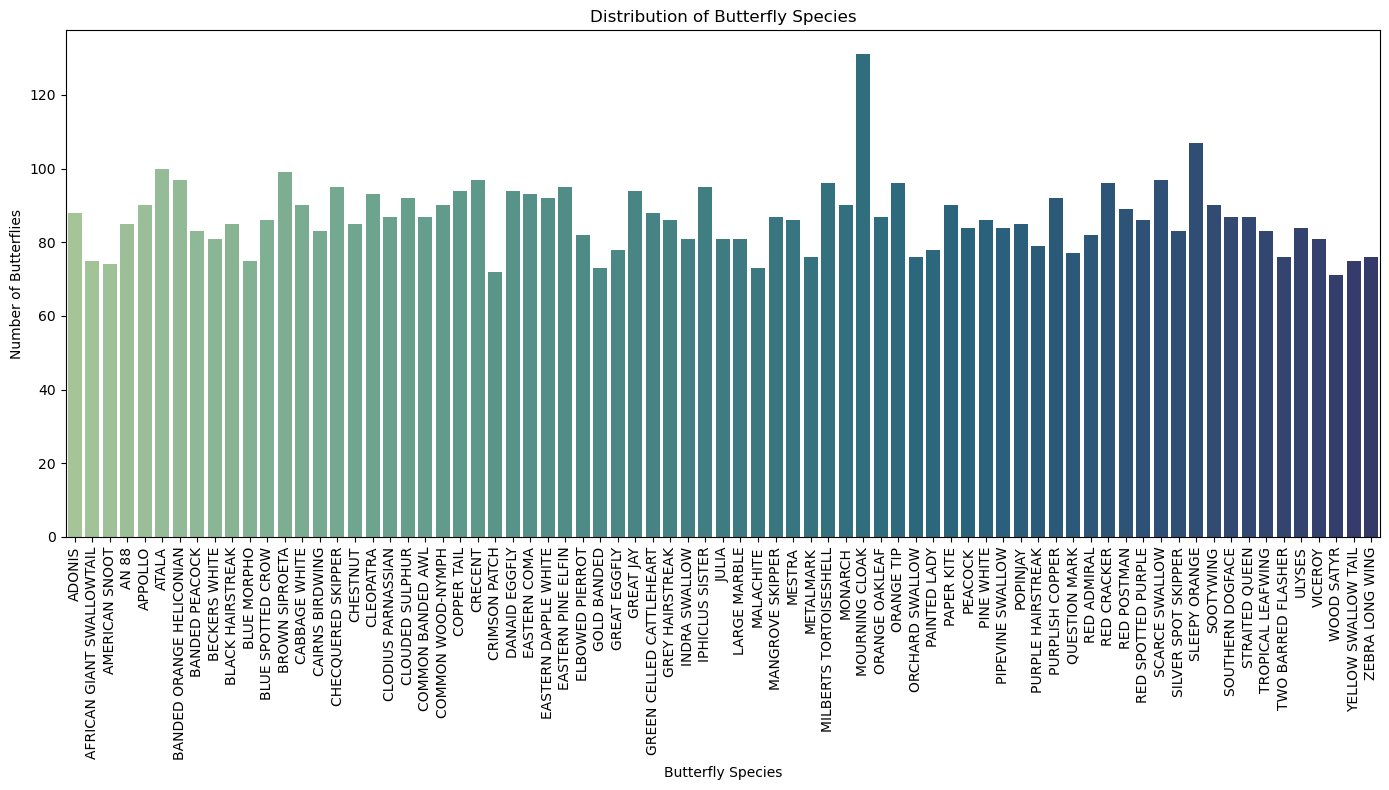

In [28]:
class_counts = species_data['label'].value_counts().sort_index()
plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='crest')
plt.title('Distribution of Butterfly Species')
plt.xlabel('Butterfly Species')
plt.ylabel('Number of Butterflies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Based on our graph the species seem to be pretty equally distributed amongst the data with the exception of the Mourning Cloak having slightly more images.

Now, let's take a look at some of our butterfly images and species(classes). 

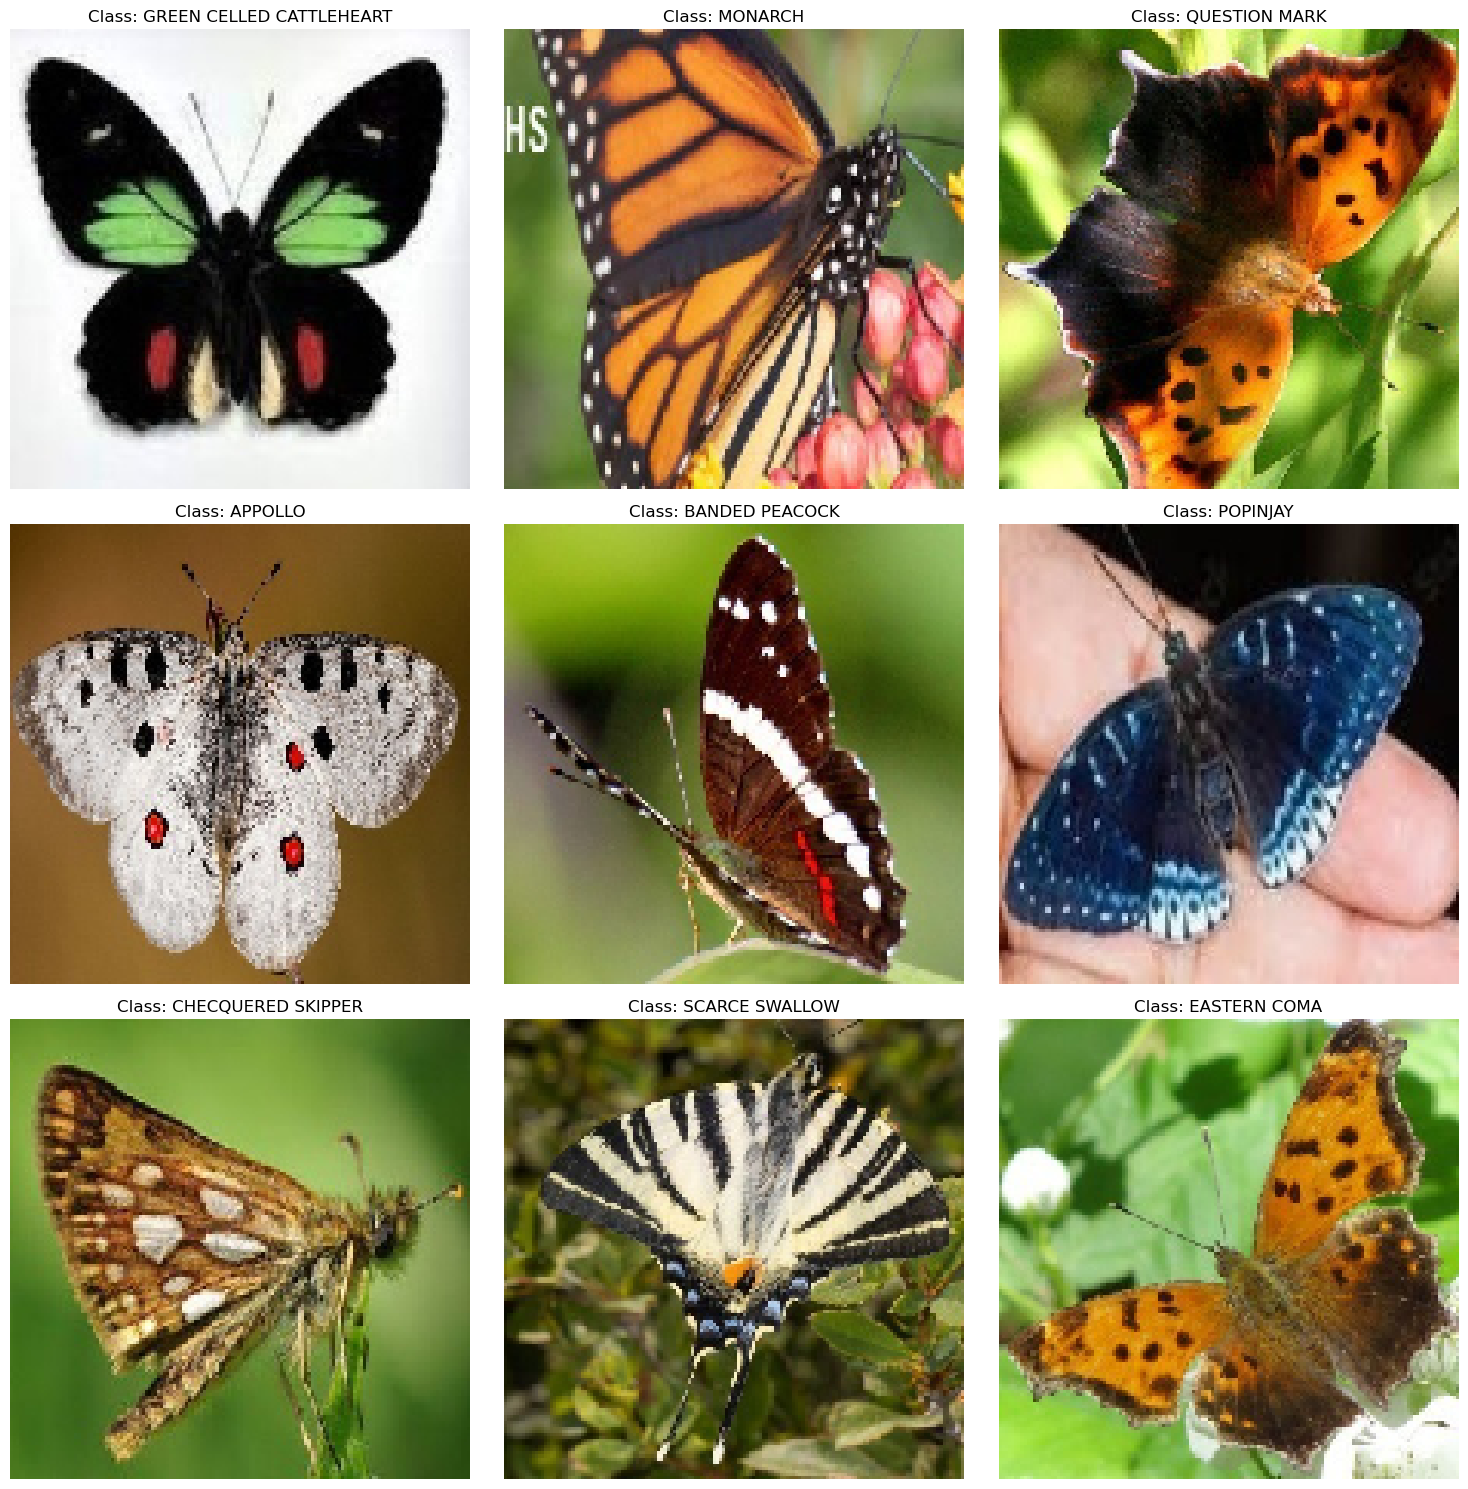

In [54]:
images = "C://Users//tanvi//train"

sample_images = species_data.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(images, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

The human eye can find the differnce between species by simply looking at the sample displayed above. Let's create a classificstion model that lets our computer classify butterflies based on details that may or may not be picked up by the human eye. For example, Eastern Comma and Question Mark look quite similar to us but there maybe be certain details that the computer picks up on to distiguish them. 

## Classification:
We are going to use a Convolutional Neural Network for the purpose of image classification. We can try differnt types of CNN models and determine the best model. 

### CNN:

#### Splitting the data 
First let's split the data into a training and testing set. 

In [105]:
image_dir = "C://Users//tanvi//train"


train_df, val_df = train_test_split(species_data, test_size=0.2, random_state=42)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


#### Model 1: simple model
I am going to start with a basic CNN model that isn't to deep. 

In [93]:
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', input_shape=(img_height, img_width, 3)))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(75))
model_1.add(Activation('softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 36, 36, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │        38,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 75)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,375,467 (20.51 MB)

 Trainable params: 5,375,467 (20.51 MB)

 Non-trainable params: 0 (0.00 B)

we have around 5 million parameters even though this is a basic model. 

Let's fit this model and see how well it performed. 

In [107]:

# Train the model
history = model_1.fit(
    train_generator,
    validation_data= val_generator,
    epochs=10,
    shuffle= True
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 367ms/step - accuracy: 0.0149 - loss: 4.3067 - val_accuracy: 0.0685 - val_loss: 4.0854
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - accuracy: 0.0539 - loss: 4.0776 - val_accuracy: 0.1946 - val_loss: 3.1700
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 0.1463 - loss: 3.3822 - val_accuracy: 0.2685 - val_loss: 2.6990
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.2058 - loss: 3.0027 - val_accuracy: 0.3569 - val_loss: 2.3846
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 300ms/step - accuracy: 0.2494 - loss: 2.8156 - val_accuracy: 0.3854 - val_loss: 2.2157
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.2845 - loss: 2.6528 - val_accuracy: 0.4300 - val_loss: 2.0640
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.3121 - loss: 2.4916 - val_accuracy: 0.4854 - val_loss: 1.8885
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.3483 - loss: 2

In [115]:
val_loss, val_accuracy = model_1.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5069 - loss: 1.7883
Validation Accuracy: 50.54%


We can see that this simple model starts with an accuracy of 50%. We can now build denser models to get a higher accuracy score. 

#### Model 2:

let's add more convolutional layers. 

In [265]:
model_2 = Sequential()


## 3x3 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (3, 3), strides = (2,2), padding='same', input_shape=(img_height, img_width, 3)))
model_2.add(Activation('relu'))

## Another 3x3 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (3, 3), strides = (2,2)))
model_2.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

## 3x3 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (3, 3), strides = (2,2), padding='same', input_shape=(img_height, img_width, 3)))
model_2.add(Activation('relu'))

## Another 3x3 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (3, 3), strides = (2,2)))
model_2.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(75))
model_2.add(Activation('softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 37, 37, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 9, 9, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 75)             │        38,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 75)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,163 (520.17 KB)

 Trainable params: 133,163 (520.17 KB)

 Non-trainable params: 0 (0.00 B)

In [267]:
# Train the model
history = model_2.fit(
    train_generator,
    validation_data= val_generator,
    epochs=40,
    shuffle= True
)

Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 266ms/step - accuracy: 0.0195 - loss: 4.2840 - val_accuracy: 0.0331 - val_loss: 3.9592
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 262ms/step - accuracy: 0.0355 - loss: 3.9655 - val_accuracy: 0.0954 - val_loss: 3.6740
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 264ms/step - accuracy: 0.0867 - loss: 3.7240 - val_accuracy: 0.1546 - val_loss: 3.2507
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.1221 - loss: 3.3907 - val_accuracy: 0.1577 - val_loss: 3.2164
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step - accuracy: 0.1470 - loss: 3.1954 - val_accuracy: 0.2654 - val_loss: 2.7619
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.2060 - loss: 3.0100 - val_accuracy: 0.2885 - val_loss: 2.5983
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 623ms/step - accuracy: 0.1939 - loss: 2.9455 - val_accuracy: 0.2962 - val_loss: 2.5767
Epoch 8/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step - accuracy: 0.2465 - loss: 

In [269]:
val_loss, val_accuracy = model_2.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6141 - loss: 1.3028
Validation Accuracy: 61.92%


This is much better. Our validation accuracy is 61% which is better than the basic model's performance. 
Let's graph this out to see how the accuracy changes. 

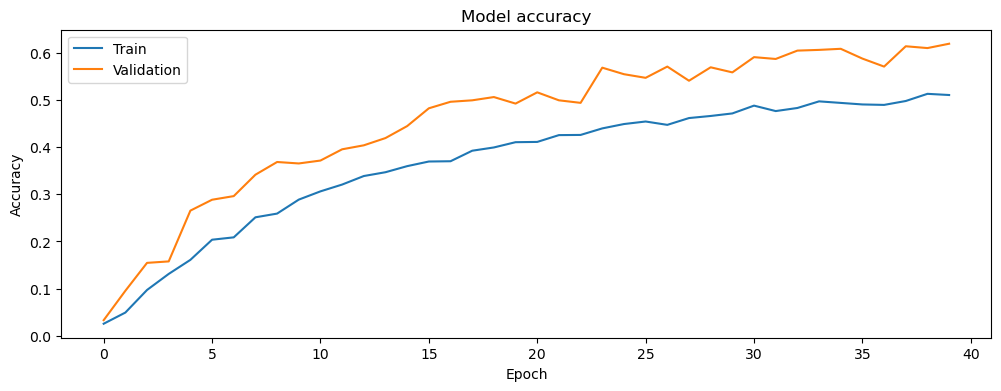

In [272]:
plt.figure(figsize=(12, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


We can see that as the number of epochs increase, the model accuracy increases and so does the validation set accuracy. 

Let's try one more variation of the CNN model.

#### Model 3

Let's use transfer learning to improve our results. 
I will now try a VGG16 model. 
A VGG model allows for more deeper layers. 
Based on the previous models, we can tell that as we increased the layers, the better the the validation accuracy score. So, we can try using a transfer learning technique. 

In [248]:
# Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(150, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
output = Dense(75, activation='softmax')(x)  # Adjust the number of classes

# Define the model
model_3 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model_3.summary()

Model: "functional_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 75, 75, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 75, 75, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 75, 75, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 75, 75, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 37, 37, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 37, 37, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 37, 37, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 37, 37, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,393,939 (12.95 MB)

 Trainable params: 165,075 (644.82 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [250]:
# Unfreeze some layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model again
history_finetune = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    shuffle=True
)

Epoch 1/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 65s 363ms/step - accuracy: 0.0112 - loss: 5.3873 - val_accuracy: 0.0266 - val_loss: 4.6131
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0000e+00 - loss: 5.0812 - val_accuracy: 0.0266 - val_loss: 4.6053
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - accuracy: 0.0237 - loss: 4.7908 - val_accuracy: 0.0469 - val_loss: 4.2252
Epoch 4/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.0312 - loss: 4.7121 - val_accuracy: 0.0453 - val_loss: 4.2254
Epoch 5/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 58s 356ms/step - accuracy: 0.0328 - loss: 4.4611 - val_accuracy: 0.0867 - val_loss: 3.9776
Epoch 6/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.0625 - loss: 4.4194 - val_accuracy: 0.0844 - val_loss: 3.9846
Epoch 7/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - accuracy: 0.0580 - loss: 4.2027 - val_accuracy: 0.1453 - val_loss: 3.7996
Epoch 8/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.1250 - loss: 3.922

It seems like the model is getting better so let's try adding 10 more epochs without refitting the model. 

In [255]:
history_additional = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Number of additional epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    shuffle=True
)

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - accuracy: 0.4618 - loss: 2.1762 - val_accuracy: 0.7070 - val_loss: 1.4003
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5312 - loss: 2.4213 - val_accuracy: 0.7039 - val_loss: 1.3973
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 58s 359ms/step - accuracy: 0.4912 - loss: 2.0636 - val_accuracy: 0.7133 - val_loss: 1.3385
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5625 - loss: 1.8729 - val_accuracy: 0.7156 - val_loss: 1.3336
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 0.4986 - loss: 2.0209 - val_accuracy: 0.7305 - val_loss: 1.2702
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5312 - loss: 1.4161 - val_accuracy: 0.7312 - val_loss: 1.2647
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 57s 353ms/step - accuracy: 0.5254 - loss: 1.9346 - val_accuracy: 0.7391 - val_loss: 1.2153
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5938 - loss: 1.8676 - 

In [257]:
val_loss, val_accuracy = model_3.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.7654 - loss: 1.0858
Validation Accuracy: 75.23%


it seems that the model is doing better as we train it more. Let's add another 10 epochs. 


In [260]:
history_additional_2 = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Number of additional epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    shuffle=True
)

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 60s 370ms/step - accuracy: 0.5481 - loss: 1.7910 - val_accuracy: 0.7602 - val_loss: 1.1147
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.3750 - loss: 2.3545 - val_accuracy: 0.7609 - val_loss: 1.1095
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 58s 357ms/step - accuracy: 0.5525 - loss: 1.8354 - val_accuracy: 0.7672 - val_loss: 1.0647
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5312 - loss: 1.8550 - val_accuracy: 0.7641 - val_loss: 1.0709
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - accuracy: 0.5646 - loss: 1.7384 - val_accuracy: 0.7758 - val_loss: 1.0204
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7812 - loss: 1.3745 - val_accuracy: 0.7734 - val_loss: 1.0264
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 59s 366ms/step - accuracy: 0.5743 - loss: 1.6721 - val_accuracy: 0.7844 - val_loss: 0.9864
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5000 - loss: 1.8758 - 

In [262]:
val_loss, val_accuracy = model_3.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.7941 - loss: 0.9489
Validation Accuracy: 79.38%


We can see that the accuracy keeps improving. 

Out of the three models. Model 3, model using mobile net is the most efficient model with the bes accuracy performance that seems to increase as we train it more. 

Let's take a look at the accuracy graph. 

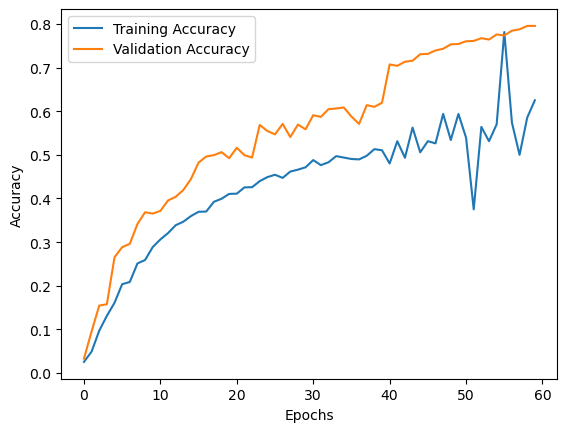

In [278]:
# Combine all histories
history.history['accuracy'].extend(history_additional.history['accuracy'])
history.history['val_accuracy'].extend(history_additional.history['val_accuracy'])
history.history['loss'].extend(history_additional.history['loss'])
history.history['val_loss'].extend(history_additional.history['val_loss'])

history.history['accuracy'].extend(history_additional_2.history['accuracy'])
history.history['val_accuracy'].extend(history_additional_2.history['val_accuracy'])
history.history['loss'].extend(history_additional_2.history['loss'])
history.history['val_loss'].extend(history_additional_2.history['val_loss'])

# Now you can plot the combined history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that the validation accuracy score keeps increasing as we increase the number of epochs or run throughs of the data. 

#### Prediction:
Now that we found the best model, we can finally make a prediciton on our test data. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


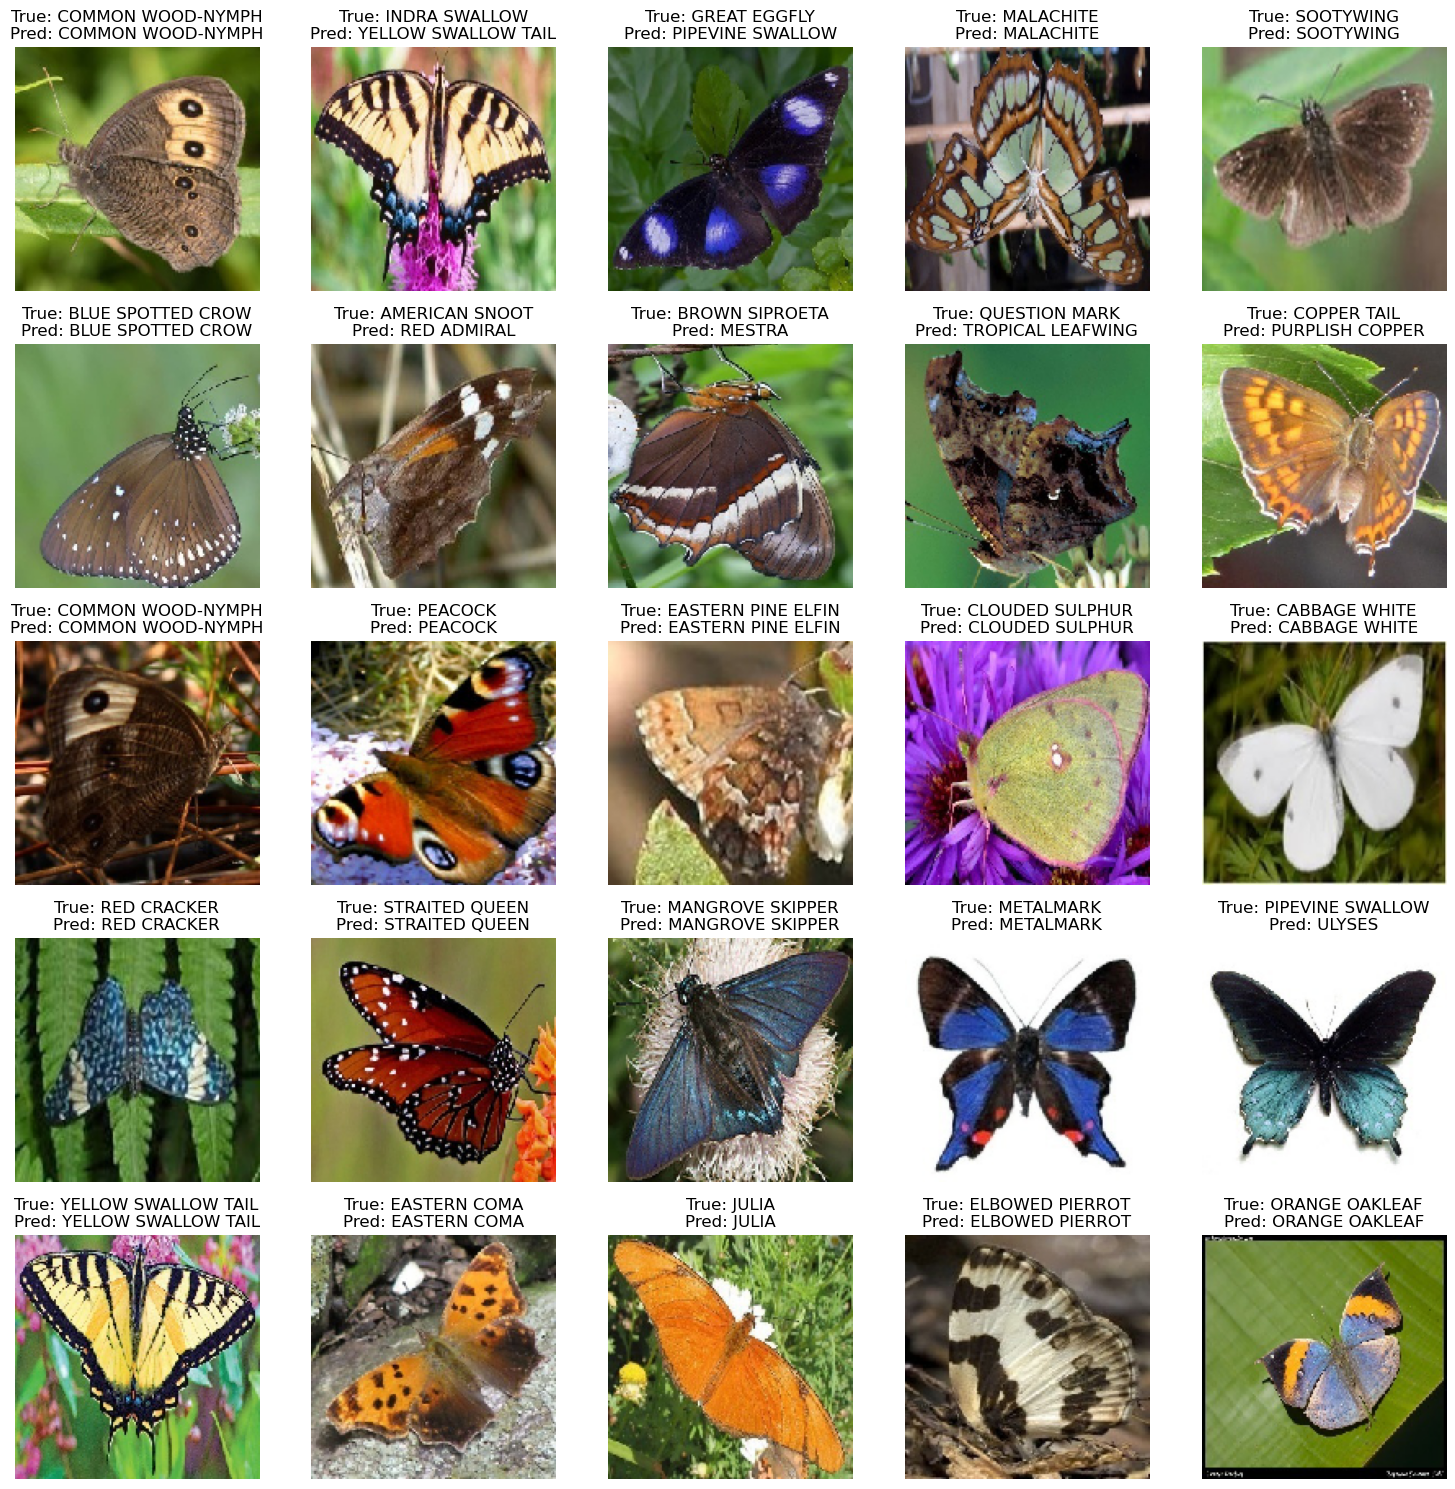

In [288]:
val_images, val_labels = next(val_generator)

pred_labels = model_3.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=25)

We can see that our model did a pretty good job of classifying the butterflies. Out of 25 it correctly classified 80% of teh butterflies which is pretty accurate with our model. 
If we keep training our model on the data by increasing number of epochs and fine tuning the model with different parameters, we can increase the accuracy further. 
Finally, because this is a dataset that consists of images with fine details, it is important to further fine tune models to be able to capture all these details. We also need to keep in mind that the more complex we make our model, the more likely it is that the model might overfit the data so we must add parameters to combat this. 

#### Bonus Question:
What is your favorite butterfly? 